<a href="https://colab.research.google.com/github/apof/ChAI---Deep-Kernel-Learning-combining-GPs-with-DL/blob/main/%CE%91%CE%BD%CF%84%CE%AF%CE%B3%CF%81%CE%B1%CF%86%CE%BF_Deep_Kernel_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy


import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils
import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/single_h_aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/single_h_aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/single_h_aluminium_dates')'''

aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/single_f_aluminium_vectors')
aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/single_f_aluminium_labels')
aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/single_f_aluminium_dates')

In [ ]:
train_batches,validation_batches,test_batches = utils.train_test_split(aluminium_inputs,aluminium_labels,aluminium_dates,aluminium_inputs.shape[0],0.8,0.7,0)

In [ ]:
train_data,train_labels,train_dates = train_batches[0]
test_data,test_labels,test_dates = test_batches[0]
val_data,val_labels,val_dates = validation_batches[0]

In [ ]:
train_data = torch.from_numpy(train_data).to(device)
train_labels = torch.from_numpy(train_labels).to(device)
test_data = torch.from_numpy(test_data).to(device)
test_labels = torch.from_numpy(test_labels).to(device)
val_data = torch.from_numpy(val_data).to(device)
val_labels = torch.from_numpy(val_labels).to(device)
train_data = torch.squeeze(train_data, dim = 1)
test_data = torch.squeeze(test_data, dim = 1)
val_data = torch.squeeze(val_data, dim = 1)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)

torch.Size([672, 55])
torch.Size([672])
torch.Size([50, 55])
torch.Size([50])
torch.Size([118, 55])
torch.Size([118])


In [ ]:
representation_dim = 2
KERNEL = 'RBF'
#KERNEL = 'SKI'
#KERNEL = 'MIX'

In [ ]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            if(KERNEL == 'SKI'):
                self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=representation_dim)),
                    num_dims=representation_dim, grid_size=100
                )
            elif(KERNEL == 'RBF'):
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            else:
                self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=representation_dim)
                
            self.feature_extractor = models.MLPFeatureExtractor(train_data.size(-1),representation_dim)
            #self.feature_extractor = RnnRegressor(device,params_dictionary,0)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            #projected_x = self.feature_extractor((x,None,None))
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            #projected_x = projected_x.to(dtype=torch.double)

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
        
        def get_representation(self,x):
            return self.feature_extractor(x)   

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_data,train_labels, likelihood).double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 5000

training_loss = []
validation_loss = []

def train():
    
    best_cost=1000000 
    stop = False
    last_improvement=0
    require_improvement = 100
    best_model = None
    epoch = 0
    
    while(stop == False):
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()
        
        epoch += 1
        
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_data)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_labels)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        print("epoch  " + str(epoch+1) + " " + str(training_loss[-1]))
        clear_output(wait=True)
        
        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()
                
        with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.use_toeplitz(False):
            ## Calculate the validation loss
            val_loss = -mll(model(val_data), val_labels)
            validation_loss.append(val_loss.item())
            
            
            avg_cost = val_loss
            if avg_cost < best_cost:
                best_cost = avg_cost
                last_improvement = 0
                best_model_state = copy.deepcopy(model.state_dict())
                torch.save(best_model_state, 'DKL.pt')
            else:
                last_improvement +=1
                
            if last_improvement > require_improvement:
                print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
                # Break out from the loop.
                stop = True
        

%time train()

No improvement found during the last iterations, stopping optimization at epoch: 111
CPU times: user 3.21 s, sys: 179 ms, total: 3.39 s
Wall time: 3.25 s


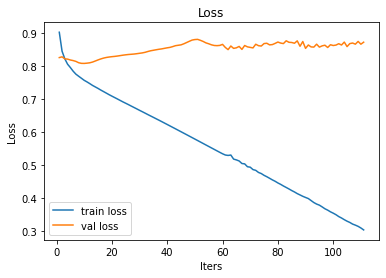

In [ ]:
index = [i+1 for i in range(len(training_loss))]
plt.plot(index, training_loss, label = "train loss")
plt.plot(index, validation_loss, label = "val loss")
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
likelihood.eval()
predictions = []

#data= torch.cat((val_data, test_data), 0)
#labels = torch.cat((val_labels, test_labels), 0)
data = val_data
labels = val_labels


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions.append(likelihood(model(data)))


In [ ]:
pred_means = []
pred_uconf = []
pred_lconf = []

for p in predictions:
    pred_means.append(p.mean.cpu().numpy())
    l, u = p.confidence_region()
    pred_lconf.append(l.cpu().detach().numpy())
    pred_uconf.append(u.cpu().detach().numpy())
pred_means = pred_means[0]
pred_uconf  = pred_uconf[0]
pred_lconf = pred_lconf[0]

In [ ]:
def find_bound_coverage(pred,u_bound,l_bound):
    inside = 0
    outside = 0
    for i,p in enumerate(pred):
        if(p < u_bound[i] and p > l_bound[i]):
            inside += 1
        else:
            outside += 1
    return (inside * 100)/len(pred), (outside * 100)/len(pred)

In [ ]:
inside_percenatge, outside_percentage = find_bound_coverage(labels,pred_uconf,pred_lconf)

In [ ]:
print('Inside Percenatge: ' + str(inside_percenatge))
print('Outside Percenatge: ' + str(outside_percentage))

Inside Percenatge: 88.13559322033899
Outside Percenatge: 11.864406779661017


In [ ]:
index = [i+1 for i in range(pred_means.shape[0])]

In [ ]:
print(len(labels))
print(len(pred_means))

118
118


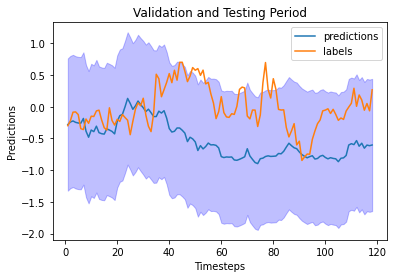

In [ ]:
fig, ax = plt.subplots()
ax.plot(index,pred_means,label = 'predictions')
ax.plot(index,labels.cpu().detach().numpy(),label = 'labels')
ax.fill_between(index, pred_lconf, pred_uconf, color='b', alpha=.25)
plt.xlabel('Timesteps')
plt.ylabel('Predictions')
plt.title('Validation and Testing Period')
plt.legend()
plt.show()

In [ ]:
low_dim_represenations = model.get_representation(train_data).cpu().detach().numpy()

In [ ]:
x = low_dim_represenations[:,0]
y = low_dim_represenations[:,1]
z = low_dim_represenations[:,2]

IndexError: ignored

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z)

ax.view_init(-140, 600)
